Potential-Based Reward Shaping
See "Policy invarianec under reward transformations: Theory and application to reawrd shaping" by Ng. et al.
https://people.eecs.berkeley.edu/~russell/papers/icml99-shaping.pdf

In [1]:
using CommonRLInterface: actions, act!, observe, reset!, terminated, observations
using CommonRLInterface.Wrappers: QuickWrapper

import POMDPs: initialstate
using POMDPModels: SimpleGridWorld, render
using StaticArrays: SA
using POMDPTools: Deterministic, MDPCommonRLEnv

using Plots
using Statistics: mean, std

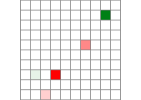

In [2]:
mdp = SimpleGridWorld(;
    rewards = Dict(
        SA[9,9]=> 10.0,
        SA[3,1]=> -2.0,
        SA[4,3]=>-10.0,
        SA[2,3]=>  1.0,
        SA[7,6]=> -5.0
    )
)

initialstate(m::SimpleGridWorld) = Deterministic(SA[1,1])

env = MDPCommonRLEnv(mdp)

render(mdp)

In [22]:
function evaluate(env, Q; n_episodes=1000, max_steps=500, discount=1.0)
    reward = 0.0
    
    for _ = 1:n_episodes
        reset!(env)
        
        for step in 1:max_steps
            s = observe(env)
            a = argmax(a->Q[s,a], actions(env))
            reward += discount^(step-1) *act!(env,a)
            
            terminated(env) && break
        end
    end
    
    return reward/n_episodes
end

function q_learning(env; 
        test_env = deepcopy(env), 
        n_steps = 1_000_000, 
        explore_steps = 1_000_000, 
        gamma = 0.99, 
        eval_every = 4_000, 
        lr = 0.05
    )
    
    Q = Dict((s,a)=>0.0 for s in observations(env), a in actions(env))
    steps, rewards = Int64[], Float64[]
    
    reset!(env)
    
    for step = 1:n_steps
        epsilon = max(0.05, 1.0 - step/explore_steps)
        
        s = observe(env)
        a = (rand() > epsilon) ? argmax(a->Q[s,a], actions(env)) : rand(actions(env))
        r = act!(env,a)
        sp = observe(env)
        terminated(env) && reset!(env)

        target = r + gamma * maximum(ap->Q[sp,ap], actions(env))
        Q[s,a] += lr * (target - Q[s,a])
        
        if step % eval_every == 0
            push!(steps, step)
            push!(rewards, evaluate(test_env, Q))
        end
    end
    
    return Dict("steps"=>steps, "rewards"=>rewards, "Q"=>Q)
end

function data_smoothing(y_data; k=10)
    N = size(y_data,1)
    y_mean, y_std = zeros(N), zeros(N)
    for ii = 1:N
        sample_data = y_data[max(1,ii-k):min(N,ii+k), :]
        y_mean[ii] = mean(sample_data)
        y_std[ii] = std(sample_data)
    end
    return y_mean, y_std
end

data_smoothing (generic function with 1 method)

Phi is your initial estimate of the value function. 
A good estimate will allow for faster learning, while a poor estimate can hard learning.

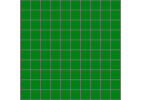

In [20]:
Phi(s) = 10.0
# Phi(s) = 10.0 * 0.99 ^ sum(abs.(s .- SA[9,9]))
# Phi(s) = 0.99 ^ sum(abs.(s .- SA[9,9]))

mn, mx = extrema(Phi, observations(env))
render(mdp; color=s->Phi(s), colormin=mn-1e-3, colormax=mx) # adjust colormin and colormax as nessisary

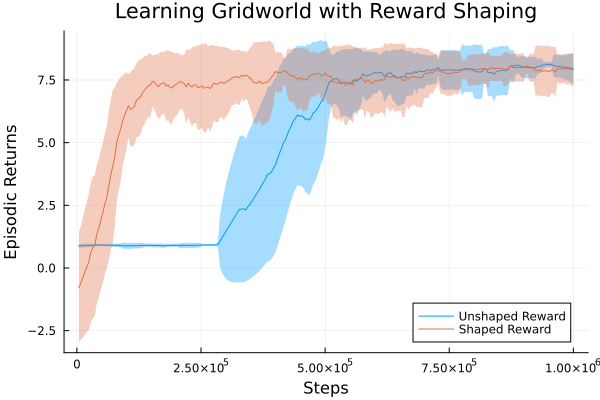

In [25]:
gamma = 0.99 # training discount, evaluation is undiscounted

env_shaped = QuickWrapper(
    env;
    act! = (env,a) -> begin
        s = observe(env)
        r = act!(env,a)
        sp = observe(env)
        
        # Termination can be handled by either taking Phi(s_terminal) = 0, or taking an infinte sum.
        if terminated(env)
            F = -Phi(s)
        else
            F = gamma * Phi(sp) - Phi(s)
        end
        
        return r + F
    end
)

test_env = deepcopy(env)

N = 5
unshaped_reward = [q_learning(env; test_env, gamma) for _ in 1:N]
shaped_reward = [q_learning(env_shaped; test_env, gamma) for _ in 1:N]

p = plot()
for (c, (data_vec, label)) in enumerate(zip([unshaped_reward, shaped_reward], ["Unshaped Reward", "Shaped Reward"]))
    x = data_vec[1]["steps"]
    y_data = reduce(hcat, data["rewards"] for data in data_vec)
    y_mean, y_std = data_smoothing(y_data; k=5)
    
    plot!(p, x, y_mean-y_std; fillrange=y_mean+y_std, fillalpha=0.35, linealpha=0, label=false, c)
    plot!(p, x, y_mean; c, label)
end
plot!(p, xlabel="Steps", ylabel="Episodic Returns", title="Learning Gridworld with Reward Shaping")
display(p)
# Shaded region is standard deviation over several seeds. 
# High-variance regions may not be accurately depicted (i.e. some seeds are reaching the goal region, while others are not)